In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

import os
import json
from tqdm import tqdm
import time

from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForMaskedLM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/compliance/OPP-115/'

In [ ]:
def load_data(path):
  train_df = pd.read_csv(path + 'train_aug_df.csv')
  test_df = pd.read_csv(path + 'test_df.csv')
  val_df = pd.read_csv(path + 'val_df.csv')
  return train_df, val_df, test_df

train_df, val_df, test_df = load_data(path)
print("train data shape: ", train_df.shape)
print("val data shape: ", val_df.shape)
print("test data shape: ", test_df.shape)

train data shape:  (17612, 13)
val data shape:  (2162, 12)
test data shape:  (2162, 12)


### 1. Train data

In [ ]:
train_df.head(2)

,Unnamed: 0.1,Unnamed: 0,doc_id,test_category,segment_number,unique_policy_identifier,label,policy_category,segment_details,policy_date,url,policy_chunk,sub_labels
0,0,0,23954.0,test_category_labeling_highlight_upitt,123.0,3708.0,42.0,Other,"{""Other Type"": {""endIndexInSegment"": 276, ""sta...",5/29/15,https://www.allstate.com/about/privacy-stateme...,Please send requests to: Allstate Insurance Co...,['Other Type']
1,1,1,17925.0,test_category_labeling_highlight_fordham_ccccc,117.0,3849.0,15.0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""changing the...",5/11/09,http://www.pbs.org/about/policies/privacy-policy/,changing the settings in your web browser Not ...,"['Choice Type', 'Choice Scope', 'User Type', '..."


In [ ]:
train_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [ ]:
train_df.head(2)

,doc_id,test_category,segment_number,unique_policy_identifier,label,policy_category,segment_details,policy_date,url,policy_chunk,sub_labels
0,23954.0,test_category_labeling_highlight_upitt,123.0,3708.0,42.0,Other,"{""Other Type"": {""endIndexInSegment"": 276, ""sta...",5/29/15,https://www.allstate.com/about/privacy-stateme...,Please send requests to: Allstate Insurance Co...,['Other Type']
1,17925.0,test_category_labeling_highlight_fordham_ccccc,117.0,3849.0,15.0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""changing the...",5/11/09,http://www.pbs.org/about/policies/privacy-policy/,changing the settings in your web browser Not ...,"['Choice Type', 'Choice Scope', 'User Type', '..."


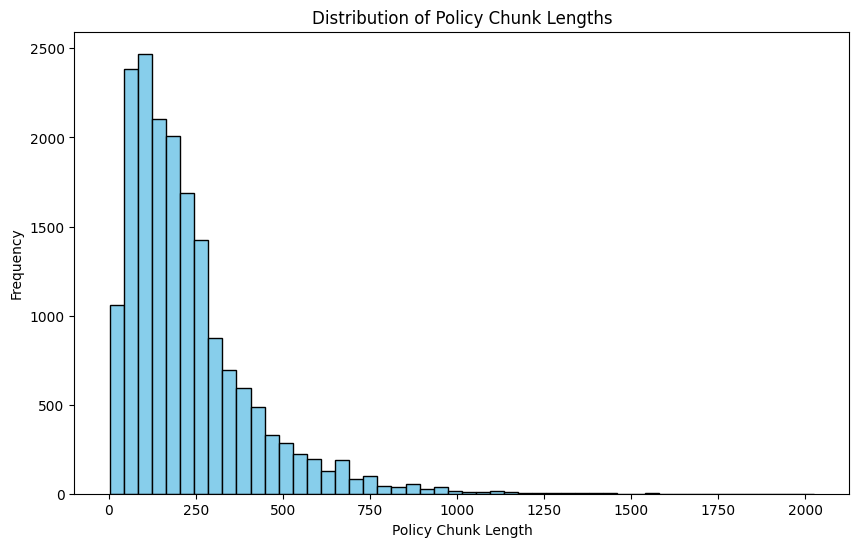

In [ ]:
train_df['policy_chunk_length'] = train_df['policy_chunk'].apply(len)

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(train_df['policy_chunk_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Policy Chunk Lengths')
plt.xlabel('Policy Chunk Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

def prepare_policy_data(train_df, val_df, test_df):
    """
    Prepares the policy dataset for multi-class classification.

    Args:
    - train_df: DataFrame containing the training dataset with columns 'policy_chunk' and 'policy_category'.
    - val_df: DataFrame containing the validation dataset with columns 'policy_chunk' and 'policy_category'.
    - test_df: DataFrame containing the test dataset with columns 'policy_chunk' and 'policy_category'.

    Returns:
    - train_texts, val_texts, test_texts: Lists containing texts for training, validation, and testing.
    - train_labels, val_labels, test_labels: Arrays containing encoded labels for training, validation, and testing.
    - target_names: List of unique labels (policy categories).
    """
    le = LabelEncoder()

    all_labels = pd.concat([train_df['policy_category'], val_df['policy_category'], test_df['policy_category']])
    le.fit(all_labels)

    train_labels = le.transform(train_df['policy_category'])
    val_labels = le.transform(val_df['policy_category'])
    test_labels = le.transform(test_df['policy_category'])

    train_texts = train_df['policy_chunk'].tolist()
    val_texts = val_df['policy_chunk'].tolist()
    test_texts = test_df['policy_chunk'].tolist()

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, le.classes_

train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, target_names = prepare_policy_data(train_df, val_df, test_df)


In [ ]:
print(train_labels[:2])
print(train_texts[:2])
print(len(target_names))

[5 9]
['Please send requests to: Allstate Insurance Company Customer Privacy Inquiries, P.O. Box 40047, Roanoke, VA 24022-0047', 'changing the settings in your web browser Not selected null Not selected cookies']
10


In [ ]:
print(len(train_texts))
print(len(val_texts))

17612
2162


In [ ]:
np_train_labels = np.asarray(train_labels)
np_val_labels = np.asarray(val_labels)
np_test_labels = np.asarray(test_labels)

In [ ]:
model_checkpoint = 'nlpaueb/legal-bert-base-uncased'

legalbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
legalbert_model = TFAutoModel.from_pretrained(model_checkpoint, from_pt=True)
legalbert_mlm = TFAutoModelForMaskedLM.from_pretrained(model_checkpoint, from_pt=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertMo

In [ ]:
max_seq_length = 300

train_encodings = legalbert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length)
val_encodings = legalbert_tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length)
test_encodings = legalbert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_seq_length)

input_ids_shape = len(train_encodings['input_ids']), len(train_encodings['input_ids'][0])
token_type_ids_shape = len(train_encodings['token_type_ids']), len(train_encodings['token_type_ids'][0])
attention_mask_shape = len(train_encodings['attention_mask']), len(train_encodings['attention_mask'][0])

print(f"Train Input IDs shape: {input_ids_shape}")
print(f"Train Token Type IDs shape: {token_type_ids_shape}")
print(f"Train Attention Mask shape: {attention_mask_shape}")

val_input_ids_shape = len(val_encodings['input_ids']), len(val_encodings['input_ids'][0])
val_token_type_ids_shape = len(val_encodings['token_type_ids']), len(val_encodings['token_type_ids'][0])
val_attention_mask_shape = len(val_encodings['attention_mask']), len(val_encodings['attention_mask'][0])

print("\nValidation Data:")
print(f"Validation Input IDs shape: {val_input_ids_shape}")
print(f"Validation Token Type IDs shape: {val_token_type_ids_shape}")
print(f"Validation Attention Mask shape: {val_attention_mask_shape}")

test_input_ids_shape = len(test_encodings['input_ids']), len(test_encodings['input_ids'][0])
test_token_type_ids_shape = len(test_encodings['token_type_ids']), len(test_encodings['token_type_ids'][0])
test_attention_mask_shape = len(test_encodings['attention_mask']), len(test_encodings['attention_mask'][0])

print("\nTest Data:")
print(f"Test Input IDs shape: {test_input_ids_shape}")
print(f"Test Token Type IDs shape: {test_token_type_ids_shape}")
print(f"Test Attention Mask shape: {test_attention_mask_shape}")


Train Input IDs shape: (17612, 300)
Train Token Type IDs shape: (17612, 300)
Train Attention Mask shape: (17612, 300)

Validation Data:
Validation Input IDs shape: (2162, 300)
Validation Token Type IDs shape: (2162, 300)
Validation Attention Mask shape: (2162, 300)

Test Data:
Test Input IDs shape: (2162, 300)
Test Token Type IDs shape: (2162, 300)
Test Attention Mask shape: (2162, 300)


In [ ]:
def compute_sample_weights(df, label_column):
    """
    Compute sample weights for multi-class classification based on class imbalance.

    Parameters:
    - df: pandas DataFrame containing the training data
    - label_column: string name of the DataFrame column containing the single class label

    Returns:
    - sample_weights: numpy array of sample weights where rows correspond to samples
    """
    label_freq = df[label_column].value_counts()

    label_weights = 1 / label_freq

    label_weights /= label_weights.sum()

    label_weight_map = label_weights.to_dict()

    sample_weights = df[label_column].map(label_weight_map).values

    return np.array(sample_weights)

sample_weights = compute_sample_weights(train_df, 'policy_category')

print(sample_weights[:5])


[0.11523021 0.09284512 0.11523021 0.11523021 0.09284512]


In [ ]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

def build_finetune_legalbert(pretrained_model_name_or_path='nlpaueb/legal-bert-base-uncased',
                             num_classes=10,
                             max_length=300,
                             hidden_size=[1024],
                             dropout=0.1,
                             learning_rate=0.00005,
                             from_pt=True):
    """
    Builds and fine-tunes a LegalBERT model for multi-class classification.

    Args:
    - pretrained_model_name_or_path: The pretrained LegalBERT model.
    - num_classes: The number of output classes.
    - max_length: The maximum length of the input sequence.
    - hidden_size: Size of the hidden layers.
    - dropout: Dropout rate.
    - learning_rate: Learning rate for Adam optimizer.
    - from_pt: Load the model from PyTorch.

    Returns:
    - classification_model: Compiled TensorFlow model ready for training.
    """
    tf.keras.backend.clear_session()

    pretrained_LLM = TFAutoModel.from_pretrained(pretrained_model_name_or_path, from_pt=from_pt, output_hidden_states=False, output_attentions=False)

    pretrained_LLM.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    llm_inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

    llm_out = pretrained_LLM(llm_inputs)
    output_token = llm_out.last_hidden_state

    hidden = tf.math.reduce_mean(output_token, axis=1)

    for i, size in enumerate(hidden_size):
        hidden = tf.keras.layers.Dense(size, activation='relu', name=f'hidden_layer_{i}')(hidden)
        hidden = tf.keras.layers.Dropout(dropout)(hidden)

    output_classification = tf.keras.layers.Dense(num_classes, activation='softmax')(hidden)
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[output_classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])


    return classification_model


In [ ]:
num_cat = len(target_names)
num_cat

10

In [ ]:
legalbert_model = build_finetune_legalbert(pretrained_model_name_or_path='nlpaueb/legal-bert-base-uncased',
                                           num_classes=num_cat,
                                           max_length=300)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
legalbert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 300)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 300)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['attention_mask[0][0]',      
 )                           ngAndCrossAttentions(last_   40         'input_ids[0][0]']           
                             hidden_state=(None, 300, 7                                       

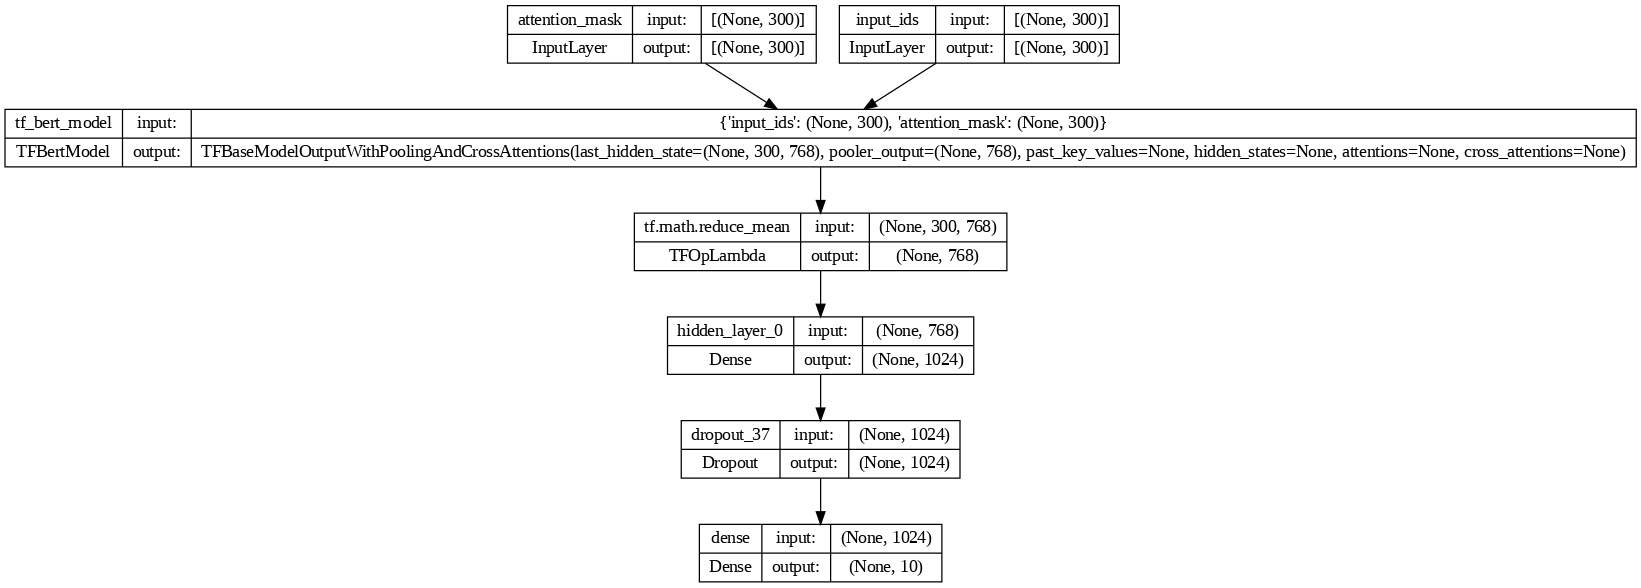

In [ ]:
keras.utils.plot_model(legalbert_model, show_shapes=True, show_dtype=False, show_layer_names=True, dpi=90)

In [ ]:
print("Length of sample weights:", len(sample_weights))
print("Number of training samples:", len(train_encodings.input_ids))


Length of sample weights: 17612
Number of training samples: 17612


In [ ]:
max_seq_length = 300

train_encodings = legalbert_tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="np")
val_encodings = legalbert_tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="np")
test_encodings = legalbert_tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors="np")

model_history = legalbert_model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y=train_labels,
    validation_data=(
        {
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        val_labels
    ),
    batch_size=8,
    epochs=1,
    sample_weight=sample_weights
)


2202/2202 [==============================] - 431s 179ms/step - loss: 0.0296 - accuracy: 0.9052 - val_loss: 0.3530 - val_accuracy: 0.9056


In [ ]:
val_score = legalbert_model.evaluate(
    x={
        'input_ids': np.array(val_encodings['input_ids']),
        'attention_mask': np.array(val_encodings['attention_mask'])
    },
    y=np.array(val_labels)
)

print('Validation Loss:', val_score[0])
print('Validation Accuracy:', val_score[1])


68/68 [==============================] - 20s 298ms/step - loss: 0.3530 - accuracy: 0.9056
Validation Loss: 0.3529530167579651
Validation Accuracy: 0.9056429266929626


In [ ]:
val_predictions = legalbert_model.predict([val_encodings['input_ids'], val_encodings['attention_mask']])

predicted_labels = np.argmax(val_predictions, axis=1)  # For multi-class classification


print(predicted_labels)


68/68 [==============================] - 23s 297ms/step
[7 9 3 ... 5 1 5]


In [ ]:
predicted_labels = np.argmax(val_predictions, axis=1)  # For multi-class classification

predicted_class_names = [target_names[label] for label in predicted_labels]

print(predicted_class_names[:10])

['Third Party Sharing/Collection', 'User Choice/Control', 'First Party Collection/Use', 'International and Specific Audiences', 'First Party Collection/Use', 'First Party Collection/Use', 'Data Security', 'User Choice/Control', 'First Party Collection/Use', 'Other']


68/68 [==============================] - 20s 297ms/step
                                      precision    recall  f1-score   support

                      Data Retention       0.95      0.75      0.84        52
                       Data Security       0.71      0.95      0.81       149
                        Do Not Track       0.87      1.00      0.93        13
          First Party Collection/Use       0.98      0.96      0.97       658
International and Specific Audiences       0.75      0.94      0.83       121
                               Other       0.97      0.76      0.85       497
                       Policy Change       0.78      0.97      0.87        60
      Third Party Sharing/Collection       0.99      0.97      0.98       378
      User Access, Edit and Deletion       0.84      0.85      0.84        80
                 User Choice/Control       0.77      0.96      0.86       154

                            accuracy                           0.91      2162
      

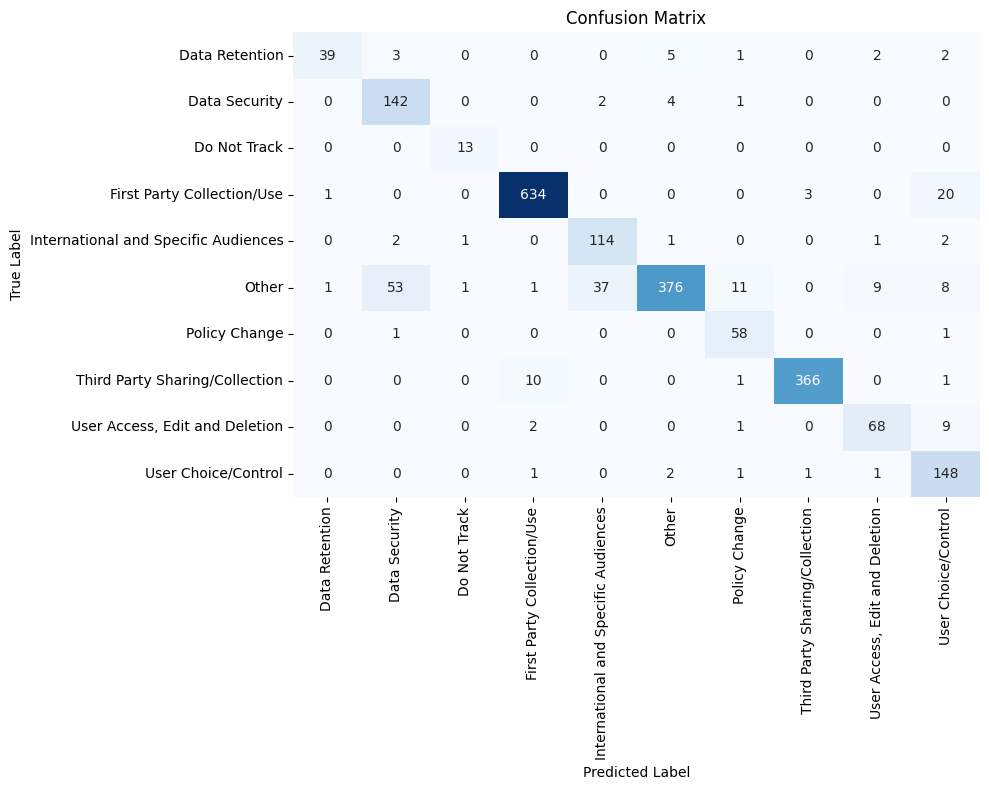

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def show_results_multiclass(model, features, true_labels, classes):
    prob_predictions = model.predict(features)

    yhat_val = np.argmax(prob_predictions, axis=1)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    conf_matrix = confusion_matrix(true_labels, yhat_val)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

show_results_multiclass(legalbert_model,
                        [val_encodings['input_ids'], val_encodings['attention_mask']],
                        val_labels,
                        target_names)


68/68 [==============================] - 20s 297ms/step
                                      precision    recall  f1-score   support

                      Data Retention       1.00      0.64      0.78        53
                       Data Security       0.64      0.93      0.76       149
                        Do Not Track       0.80      0.92      0.86        13
          First Party Collection/Use       0.98      0.99      0.98       658
International and Specific Audiences       0.77      0.91      0.84       120
                               Other       0.96      0.76      0.85       497
                       Policy Change       0.86      0.95      0.90        60
      Third Party Sharing/Collection       1.00      0.96      0.98       378
      User Access, Edit and Deletion       0.81      0.90      0.85        80
                 User Choice/Control       0.81      0.95      0.87       154

                            accuracy                           0.91      2162
      

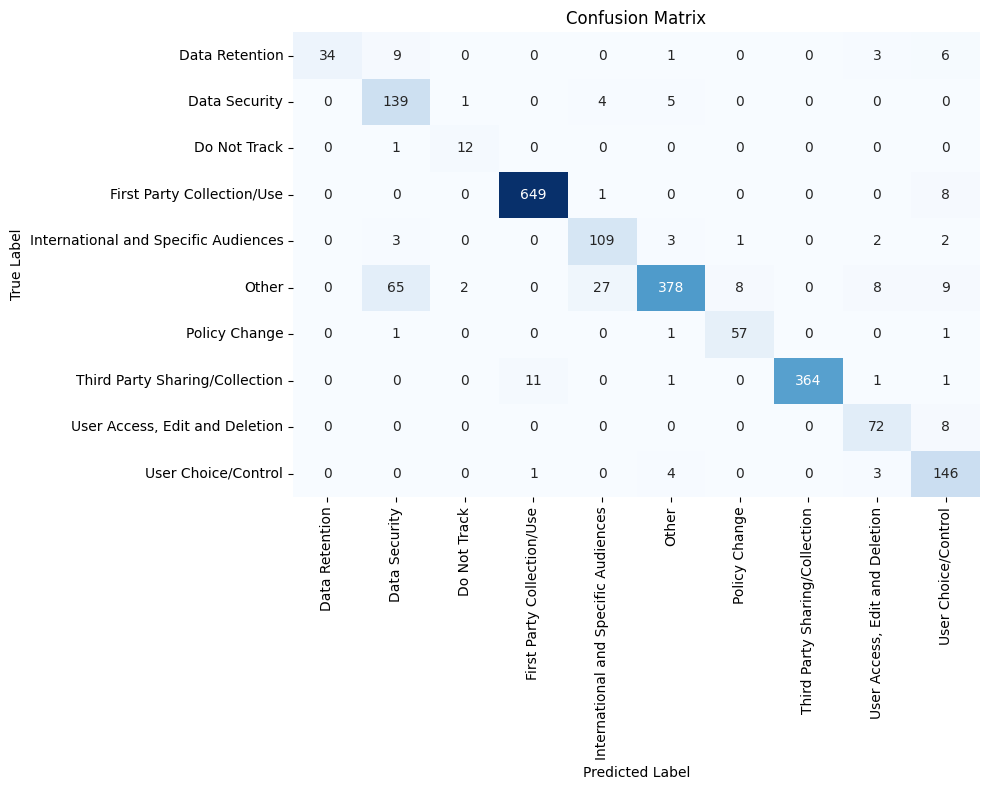

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def show_results_multiclass(model, features, true_labels, classes):
    prob_predictions = model.predict(features)

    yhat_val = np.argmax(prob_predictions, axis=1)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    conf_matrix = confusion_matrix(true_labels, yhat_val)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

show_results_multiclass(legalbert_model,
                        [test_encodings['input_ids'], test_encodings['attention_mask']],
                        test_labels,
                        target_names)


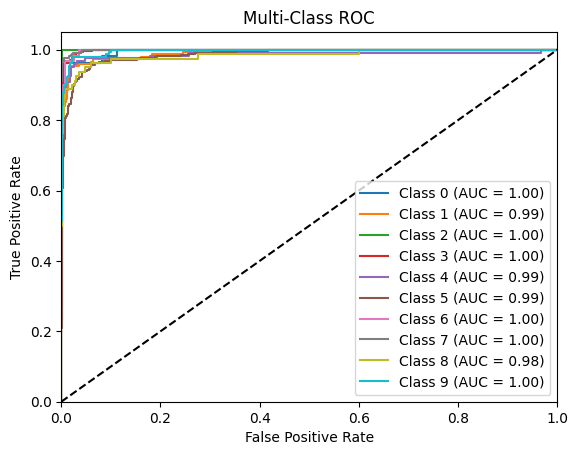

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_true_bin = label_binarize(val_labels, classes=np.arange(num_cat))

for i in range(num_cat):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc='lower right')
plt.show()


In [ ]:
legalbert_model.save(path + 'legalbert_finetuned_model')


NameError: name 'legalbert_model' is not defined

In [ ]:
from keras.layers import TFSMLayer

loaded_model = TFSMLayer(path + 'legalbert_finetuned_model', call_endpoint='serving_default')


OSError: SavedModel file does not exist at: /content/drive/MyDrive/compliance/OPP-115/legalbert_finetuned_model/{saved_model.pbtxt|saved_model.pb}

In [ ]:
import tensorflow as tf

loaded_model = tf.saved_model.load(path + 'legalbert_finetuned_model')

random_policy_text = "We may share your personal information with third-party service providers to facilitate our services, including payment processing, data analysis, email delivery, hosting services, customer service, and marketing. These third parties are authorized to use your personal information only as necessary to provide these services to us and are required to maintain the confidentiality and security of your information. We do not sell your personal information to any third parties."

random_policy_encoding = legalbert_tokenizer(
    random_policy_text,
    truncation=True,
    padding='max_length',
    max_length=300,
    return_tensors='tf'
)

input_ids = random_policy_encoding['input_ids']
attention_mask = random_policy_encoding['attention_mask']

predicted_probabilities = loaded_model.signatures['serving_default'](
    input_ids=tf.constant(input_ids),
    attention_mask=tf.constant(attention_mask)
)

predicted_class = tf.argmax(predicted_probabilities['dense'], axis=1)

print(f"Predicted category: {target_names[predicted_class[0]]}")


Predicted category: Data Security


In [ ]:
print(list(loaded_model.signatures['serving_default'].structured_outputs.keys()))


['dense']


In [ ]:
pd.set_option('display.max_colwidth', None)

test_df[['policy_chunk', 'policy_category']].head(5)


,policy_chunk,policy_category
0,update Account certain information,"User Access, Edit and Deletion"
1,"null null We use information null non-personally identifiable information in aggregate form null null to build higher quality, more useful Services by performing statistical analyses of the collective characteristics and behavior of the users of the Services, and by measuring demographics and interests regarding specific areas and features of the Services.",First Party Collection/Use
2,"Your California privacy rights. California law permits users who are California residents to request and obtain from us once a year, free of charge, a list of the third parties to whom we have disclosed their personal information (if any) for their direct marketing purposes in the prior calendar year, as well as the type of personal information disclosed to those parties. If you are a California resident and would like to request this information, please submit your request in an email to privacy@tribune.com.",International and Specific Audiences
3,"Even if the registered user chooses to opt-out of receiving e-mails from both MediaNews and third parties, MediaNews reserves the right to contact a registered user regarding account status, changes to this policy, the terms of use, license agreements and other matters relevant to the use of the MediaNews Web sites, services or software provided through the Web sites and/or the information collected.",Other
4,"you can simply ""opt out information to be collected null Not selected personal information",User Choice/Control
